# Deep Convolutional

In [ ]:
%pip install -q imageio pydot tensorflow-gpu==2.9.1 keras matplotlib graphviz moviepy scikit-image keras keras-tuner matplotlib kiwisolver scikit-learn tensorflow-io


In [1]:
import os
import keras_tuner as kt
from numpy import asarray
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import os.path
import math
import glob
import PIL
import PIL.Image
from skimage.color import lab2rgb


In [2]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision
import tensorflow_io as tfio

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    #mixed_precision.set_global_policy('mixed_float16')
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


2022-06-10 15:12:13.156599: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-10 15:12:13.178465: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-10 15:12:13.178614: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
tf.__version__


'2.9.1'

## Load and process data.
Will take advantage of built in tensorflow/keras for asynchronous load dataset from disk, rather force all data to be loaded in memory.

In [4]:
def load_from_directory(data_dir, train_subdir, test_subdir, image_size, batch_size):
    def configure_for_performance(ds, AUTOTUNE):
        ds = ds.cache()
        ds = ds.prefetch(buffer_size=AUTOTUNE)
        return ds

    data_train_dir = pathlib.Path(data_dir.as_posix() + "/" + train_subdir)
    image_count = len(list(data_train_dir.glob('**/*.??g')))
    print("{0}: Found {1} files".format(data_train_dir, image_count))
    train_ds = tf.keras.utils.image_dataset_from_directory(
        data_train_dir,
        interpolation='bilinear',
        color_mode='rgb',
        label_mode=None,
        follow_links=True,
        shuffle=False,
        image_size=image_size,
        batch_size=batch_size)

    #
    data_test_dir = pathlib.Path(data_dir.as_posix() + "/" + test_subdir)
    image_count = len(list(data_test_dir.glob('**/*.??g')))
    print("{0}: Found {1} files".format(data_test_dir, image_count))
    test_ds = tf.keras.utils.image_dataset_from_directory(
        data_test_dir,
        interpolation='bilinear',
        color_mode='rgb',
        label_mode=None,
        follow_links=True,
        shuffle=False,
        image_size=image_size,
        batch_size=batch_size)

    #
    AUTOTUNE = tf.data.AUTOTUNE
    normalization_layer = tf.keras.layers.Rescaling(1.0 / 255.0)

    @tf.function
    def preprocess_lab(img):
        image = tf.cast(img, tf.float32)

        lab = tfio.experimental.color.rgb_to_lab(image)
        l = lab[..., 0]

        l = tf.expand_dims(l, axis=-1)
        return tf.cast(tf.concat(l, axis=-1), tf.float32)

    @tf.function
    def preprocess_lab2(img):
        image = tf.cast(img, tf.float32)
        lab = tfio.experimental.color.rgb_to_lab(image)
        a = lab[..., 1]
        b = lab[..., 2]

        a = tf.expand_dims(a, axis=-1)
        b = tf.expand_dims(b, axis=-1)
        return tf.cast(tf.concat([a, b], axis=-1), tf.float32)

    # Translate [0,255] -> [-1, 1]
    normalized_train_ds = (train_ds.map(lambda x: preprocess_lab(normalization_layer(x))))

    # Translate [0,255] -> [-1, 1]
    normalized_test_ds = (test_ds.map(lambda x: (preprocess_lab2(normalization_layer(x)) * (1.0 / 128.0))))
    #train_ds = train_ds.map(lambda x: rgb2lab(x.numpy()))

    return configure_for_performance(tf.data.Dataset.zip((normalized_train_ds, normalized_test_ds)).shuffle(64), AUTOTUNE)


In [5]:
BATCH_SIZE = 48
IMAGE_SIZE = (64, 64)
EPOCHS = 256

data_directory_path = "data-colorize/"
data_dir = pathlib.Path(data_directory_path)

train_images = load_from_directory(data_dir, "", "", IMAGE_SIZE, BATCH_SIZE)

print("Number of batches {0} of {1} elements".format(
    len(train_images), BATCH_SIZE))


data-colorize: Found 14397 files
Found 14397 files belonging to 1 classes.


2022-06-10 15:12:13.878754: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-10 15:12:13.879589: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-10 15:12:13.879787: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-10 15:12:13.879919: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

data-colorize: Found 14397 files
Found 14397 files belonging to 1 classes.
Number of batches 300 of 48 elements


2022-06-10 15:12:16.839539: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


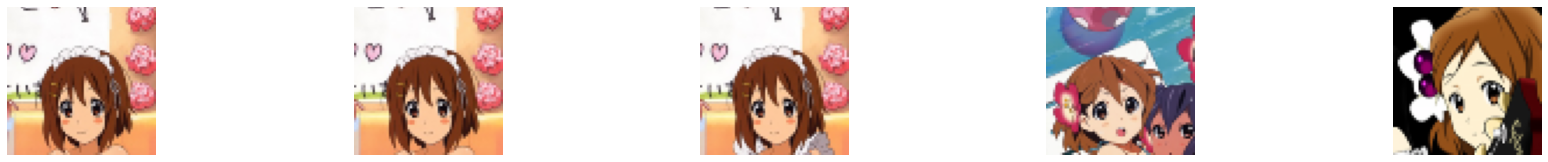

In [6]:
num_examples_to_generate = 9

plt.figure(figsize=(15 * 2, 6))
for images in train_images.take(1):
    for i in range(0, 5):
        ax = plt.subplot(1, 5, i + 1)
        trainImage, expectedImage = images
        # Transform pixel values from [-1,1] to [0,1]
        trainLAB = trainImage[i, :, :].numpy().astype(dtype='float32')
        #plt.imshow(lab2rgb(trainLAB), cmap='gray')
        plt.imshow(trainLAB)
        plt.axis("off")


        ax = plt.subplot(2, 5, 6 + i)
        expectedImage = expectedImage[i, :, :, :].numpy().astype(dtype='float32') * 128
        #expectedImage = np.append(expectedImage, trainLAB).reshape((IMAGE_SIZE[0],IMAGE_SIZE[1],3))
        RGBImage = np.zeros((IMAGE_SIZE[0],IMAGE_SIZE[1], 3))
        RGBImage[:,:,0] = trainLAB[:,:,0]
        RGBImage[:,:,1:] = expectedImage

        rgbExpected = lab2rgb(RGBImage)

       # plt.imshow(lab2rgb(expectedImage))
        plt.imshow(rgbExpected)
        plt.axis("off")
plt.show()


In [7]:
def create_model(hp, input_shape):
    model = tf.keras.Sequential()

    init = tf.keras.initializers.TruncatedNormal(stddev=0.02)

    kernel_init = hp.Choice('kernel_initializer', ['uniform', 'lecun_uniform', 'normal', 'zero',
                                                   'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'])

    model.add(layers.Input(input_shape))


    downscale_number_layer_offset = hp.Int('number_layers', min_value=3, max_value=6, step=1)

    n2 = math.log2(float(IMAGE_SIZE[0]))
    num_layers = max(int(n2) - downscale_number_layer_offset, 0)

    hp_kernel_filter_size_l0 = hp.Int('kernel_filter_downscale', min_value=4, max_value=8, step=1)


    for i in range(0, num_layers + 1):
        filter_size = 2 ** (i + hp_kernel_filter_size_l0)

        #model.add(layers.Conv2D(filter_size, (3, 3), activation='relu', padding='same', kernel_initializer=kernel_init))

        model.add(layers.Conv2D(filter_size, (3, 3), activation='relu', padding='same', kernel_initializer=kernel_init))

        model.add(layers.Conv2D(filter_size, (3, 3), activation='relu', padding='same', strides=2))
        #model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # model.add(layers.Flatten())
    hp_kernel_filter_size_latent = hp.Int('kernel_filter_latent', min_value=6, max_value=9, step=1)
    model.add(layers.Conv2D(2 **  hp_kernel_filter_size_latent, (3, 3), activation='relu', padding='same', kernel_initializer=kernel_init))
    model.add(layers.Conv2D( 2 **  (hp_kernel_filter_size_latent - 1), (3, 3), activation='relu', padding='same', kernel_initializer=kernel_init))

    hp_kernel_filter_size_l1 = hp.Int('kernel_filter_upscale', min_value=5, max_value=9, step=1)

    #upscale_number_layer_offset = hp.Int('upscale_number_layer_offset', min_value=4, max_value=6, step=1)


    for i in range(0, num_layers + 1):
        filter_size = 2 ** (hp_kernel_filter_size_l1 - i)

        #model.add(layers.Conv2D(filter_size, (2, 2), strides=(2, 2), activation='relu', padding='same'))
        #model.add(layers.Conv2D(filter_size, (3, 3), activation='relu', padding='same', kernel_initializer=kernel_init))
        model.add(layers.UpSampling2D(size=(2, 2)))
        model.add(layers.Conv2D(filter_size, (3, 3), activation='relu', padding='same', kernel_initializer=kernel_init))

    model.add(layers.Conv2D(2, (3, 3), activation='tanh', padding='same', kernel_initializer=kernel_init))
    
    hp_optimizer = hp.Choice('optimizer', ['sgd', 'adam', 'rmsprop'])

    model.compile(optimizer=hp_optimizer,
                  loss='mse',
                  metrics=['accuracy'])

    return model


In [8]:

image_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 1)

def model_builder(hp):
    model = create_model(hp, image_shape)
    return model


tuner = kt.Hyperband(model_builder,
                     objective='accuracy',
                     max_epochs=16,
                     factor=5,
                     directory='cache',
                     project_name=str.format('Colorizing - LAB - {0}', "Anime"))

stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='loss', patience=5)
tuner.search(train_images, epochs=EPOCHS, batch_size=BATCH_SIZE,
             callbacks=[stop_early], verbose=1)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_models = tuner.get_best_models(4)

model = tuner.hypermodel.build(best_hps)
model.summary()

Trial 13 Complete [00h 01m 48s]
accuracy: 0.6578997373580933

Best accuracy So Far: 0.6578997373580933
Total elapsed time: 00h 15m 03s
INFO:tensorflow:Oracle triggered exit
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 64, 64, 64)        640       
                                                                 
 conv2d_10 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 conv2d_11 (Conv2D)          (None, 32, 32, 128)       73856     
                                                                 
 conv2d_12 (Conv2D)          (None, 16, 16, 128)       147584    
                                                                 
 conv2d_13 (Conv2D)          (None, 16, 16, 256)       295168    
                                                                 
 conv2d_14 (C

In [9]:
def showResult(model, batchImage):
    maxNumImages = 5
    output = model.predict(batchImage)
    output = output * 128
    nrElements = min(len(output), maxNumImages)

    fig = plt.figure(figsize=(maxNumImages * 2, maxNumImages))
    for image in batchImage:
        for i in range(nrElements):
            trainImage, expectedImage = image

            # for TImage, ExImage in zip(train_images, expectedImage):
            ax = plt.subplot(2, maxNumImages, i + 1)
            canvas = np.zeros((IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
            canvas[:, :, 0] = trainImage[i][:, :, 0]
            canvas[:, :, 1:] = expectedImage[i][:, :, :] * 128
            # TODO Fix expected.
            # Transform pixel values from [-1,1] to [0,1]
            plt.imshow((asarray(lab2rgb(canvas)).astype(dtype='float32')))
            plt.axis("off")

            ax = plt.subplot(2, maxNumImages, maxNumImages + 1 + i)

            canvas = np.zeros((IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
            canvas[:, :, 0] = trainImage[i][:, :, 0]
            canvas[:, :, 1:] = output[i][:, :, :]

            # Transform pixel values from [-1,1] to [0,1]
            plt.imshow(asarray(lab2rgb(canvas)).astype(dtype='float32'))
            plt.axis("off")
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.close()
    #plt.show()
    return fig


class save_images(tf.keras.callbacks.Callback):

    def __init__(self, trainData, **kwargs):
        super(tf.keras.callbacks.Callback, self).__init__(**kwargs)
        self.trainData = trainData

    def on_epoch_end(self, epoch, logs=None):
        fig = showResult(self.model, self.trainData.take(1))
        fig.savefig("animeColorLAB{0}.png".format(epoch))


In [15]:

checkpoint_path = "training_anime_coloring_lab/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=0)

checkpoint = tf.train.Checkpoint(model=model)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path)).expect_partial()


# The model weights (that are considered the best) are loaded into the model.
if os.path.exists(checkpoint_path):
    model.load_weights(checkpoint_path)


model_history = model.fit(train_images,
                          epochs=EPOCHS,
                          batch_size=1,
                          verbose=1, callbacks=[cp_callback, save_images(train_images)])

model.save_weights(checkpoint_path)


Epoch 1/256
300/300 [==============================] - 7s 23ms/step - loss: 0.0050 - accuracy: 0.7932
Epoch 2/256
  1/300 [..............................] - ETA: 6s - loss: 0.0051 - accuracy: 0.7842

/media/programming/projects/machineLearning/ML/venv/lib/python3.9/site-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 3 pixels
  return func(*args, **kwargs)
/media/programming/projects/machineLearning/ML/venv/lib/python3.9/site-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 2 pixels
  return func(*args, **kwargs)


300/300 [==============================] - 7s 23ms/step - loss: 0.0050 - accuracy: 0.7934
Epoch 3/256
300/300 [==============================] - 7s 23ms/step - loss: 0.0049 - accuracy: 0.7948
Epoch 4/256
  1/300 [..............................] - ETA: 6s - loss: 0.0053 - accuracy: 0.7992

/media/programming/projects/machineLearning/ML/venv/lib/python3.9/site-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 5 pixels
  return func(*args, **kwargs)


300/300 [==============================] - 7s 23ms/step - loss: 0.0049 - accuracy: 0.7939
Epoch 5/256
300/300 [==============================] - 7s 23ms/step - loss: 0.0049 - accuracy: 0.7931
Epoch 6/256
  4/300 [..............................] - ETA: 6s - loss: 0.0049 - accuracy: 0.7697

/media/programming/projects/machineLearning/ML/venv/lib/python3.9/site-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return func(*args, **kwargs)


300/300 [==============================] - 7s 23ms/step - loss: 0.0049 - accuracy: 0.7931
Epoch 7/256
300/300 [==============================] - 7s 23ms/step - loss: 0.0049 - accuracy: 0.7947
Epoch 8/256
300/300 [==============================] - 7s 23ms/step - loss: 0.0049 - accuracy: 0.7938
Epoch 9/256
300/300 [==============================] - 7s 23ms/step - loss: 0.0050 - accuracy: 0.7942
Epoch 10/256
300/300 [==============================] - 7s 23ms/step - loss: 0.0049 - accuracy: 0.7963
Epoch 11/256
300/300 [==============================] - 7s 23ms/step - loss: 0.0049 - accuracy: 0.7930
Epoch 12/256
300/300 [==============================] - 7s 23ms/step - loss: 0.0049 - accuracy: 0.7952
Epoch 13/256
300/300 [==============================] - 7s 23ms/step - loss: 0.0049 - accuracy: 0.7934
Epoch 14/256
300/300 [==============================] - 7s 23ms/step - loss: 0.0049 - accuracy: 0.7945
Epoch 15/256
300/300 [==============================] - 7s 23ms/step - loss: 0.0049 - acc

/media/programming/projects/machineLearning/ML/venv/lib/python3.9/site-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 4 pixels
  return func(*args, **kwargs)


300/300 [==============================] - 7s 23ms/step - loss: 0.0049 - accuracy: 0.7951
Epoch 22/256
300/300 [==============================] - 7s 23ms/step - loss: 0.0049 - accuracy: 0.7944
Epoch 23/256
300/300 [==============================] - 7s 23ms/step - loss: 0.0049 - accuracy: 0.7960
Epoch 24/256
300/300 [==============================] - 7s 23ms/step - loss: 0.0049 - accuracy: 0.7941
Epoch 25/256
300/300 [==============================] - 7s 23ms/step - loss: 0.0049 - accuracy: 0.7946
Epoch 26/256
300/300 [==============================] - 7s 23ms/step - loss: 0.0049 - accuracy: 0.7949
Epoch 27/256
300/300 [==============================] - 7s 23ms/step - loss: 0.0048 - accuracy: 0.7967
Epoch 28/256
300/300 [==============================] - 7s 23ms/step - loss: 0.0049 - accuracy: 0.7944
Epoch 29/256
300/300 [==============================] - 7s 23ms/step - loss: 0.0049 - accuracy: 0.7965
Epoch 30/256
300/300 [==============================] - 7s 23ms/step - loss: 0.0049 - 

/media/programming/projects/machineLearning/ML/venv/lib/python3.9/site-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 10 pixels
  return func(*args, **kwargs)


300/300 [==============================] - 7s 23ms/step - loss: 0.0048 - accuracy: 0.7967
Epoch 37/256
300/300 [==============================] - 7s 23ms/step - loss: 0.0048 - accuracy: 0.7923
Epoch 38/256
300/300 [==============================] - 7s 23ms/step - loss: 0.0048 - accuracy: 0.7987
Epoch 39/256
300/300 [==============================] - 7s 23ms/step - loss: 0.0049 - accuracy: 0.7966
Epoch 40/256
300/300 [==============================] - 7s 23ms/step - loss: 0.0048 - accuracy: 0.7955
Epoch 41/256
300/300 [==============================] - 7s 23ms/step - loss: 0.0049 - accuracy: 0.7957
Epoch 42/256
300/300 [==============================] - 7s 23ms/step - loss: 0.0048 - accuracy: 0.7960
Epoch 43/256
300/300 [==============================] - 7s 23ms/step - loss: 0.0049 - accuracy: 0.7960
Epoch 44/256
300/300 [==============================] - 7s 23ms/step - loss: 0.0048 - accuracy: 0.7941
Epoch 45/256
300/300 [==============================] - 7s 23ms/step - loss: 0.0049 - 

/media/programming/projects/machineLearning/ML/venv/lib/python3.9/site-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 8 pixels
  return func(*args, **kwargs)


300/300 [==============================] - 7s 23ms/step - loss: 0.0048 - accuracy: 0.7973
Epoch 47/256
300/300 [==============================] - 7s 23ms/step - loss: 0.0048 - accuracy: 0.7978
Epoch 48/256
300/300 [==============================] - 7s 23ms/step - loss: 0.0048 - accuracy: 0.7960
Epoch 49/256
300/300 [==============================] - 7s 23ms/step - loss: 0.0048 - accuracy: 0.7946
Epoch 50/256
300/300 [==============================] - 7s 23ms/step - loss: 0.0048 - accuracy: 0.7975
Epoch 51/256
300/300 [==============================] - 7s 23ms/step - loss: 0.0048 - accuracy: 0.7985
Epoch 52/256
300/300 [==============================] - 7s 24ms/step - loss: 0.0048 - accuracy: 0.7961
Epoch 53/256
300/300 [==============================] - 7s 24ms/step - loss: 0.0048 - accuracy: 0.7965
Epoch 54/256
300/300 [==============================] - 7s 24ms/step - loss: 0.0048 - accuracy: 0.7956
Epoch 55/256
300/300 [==============================] - 7s 24ms/step - loss: 0.0048 - 

/media/programming/projects/machineLearning/ML/venv/lib/python3.9/site-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 6 pixels
  return func(*args, **kwargs)
/media/programming/projects/machineLearning/ML/venv/lib/python3.9/site-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 9 pixels
  return func(*args, **kwargs)


300/300 [==============================] - 7s 24ms/step - loss: 0.0048 - accuracy: 0.7984
Epoch 58/256
300/300 [==============================] - 14s 46ms/step - loss: 0.0048 - accuracy: 0.7955
Epoch 59/256
300/300 [==============================] - 7s 24ms/step - loss: 0.0048 - accuracy: 0.7974
Epoch 60/256
300/300 [==============================] - 7s 24ms/step - loss: 0.0048 - accuracy: 0.7969
Epoch 61/256
300/300 [==============================] - 7s 25ms/step - loss: 0.0048 - accuracy: 0.7960
Epoch 62/256
300/300 [==============================] - 7s 25ms/step - loss: 0.0048 - accuracy: 0.7959
Epoch 63/256
  1/300 [..............................] - ETA: 6s - loss: 0.0063 - accuracy: 0.7865

/media/programming/projects/machineLearning/ML/venv/lib/python3.9/site-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 15 pixels
  return func(*args, **kwargs)
/media/programming/projects/machineLearning/ML/venv/lib/python3.9/site-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 26 pixels
  return func(*args, **kwargs)


300/300 [==============================] - 7s 25ms/step - loss: 0.0048 - accuracy: 0.7963
Epoch 64/256
300/300 [==============================] - 7s 25ms/step - loss: 0.0048 - accuracy: 0.7974
Epoch 65/256
300/300 [==============================] - 7s 25ms/step - loss: 0.0048 - accuracy: 0.7969
Epoch 66/256
300/300 [==============================] - 7s 25ms/step - loss: 0.0048 - accuracy: 0.7959
Epoch 67/256
300/300 [==============================] - 7s 25ms/step - loss: 0.0048 - accuracy: 0.7965
Epoch 68/256
300/300 [==============================] - 7s 23ms/step - loss: 0.0048 - accuracy: 0.7958
Epoch 69/256
300/300 [==============================] - 7s 23ms/step - loss: 0.0048 - accuracy: 0.7976
Epoch 70/256
300/300 [==============================] - 7s 23ms/step - loss: 0.0048 - accuracy: 0.7968
Epoch 71/256
300/300 [==============================] - 7s 23ms/step - loss: 0.0048 - accuracy: 0.7960
Epoch 72/256
300/300 [==============================] - 7s 23ms/step - loss: 0.0048 - 

KeyboardInterrupt: 

In [16]:
model.save("dc-anime-colorization-lab.h5")

# Result

In [17]:
#loss, acc = model.evaluate(test_images, test_labels, verbose=2)

In [18]:
def plotCostHistory(history, loss_label="", val_label="", title="", x_label="", y_label=""):
    plt.figure()
    for k, v in history.items():
        plt.plot(v, label=k)
    plt.title(label=title)
    plt.ylabel(ylabel=y_label)
    plt.xlabel(xlabel=x_label)
    plt.legend(loc="upper left")
    plt.show()
    plt.savefig(title + ".png")


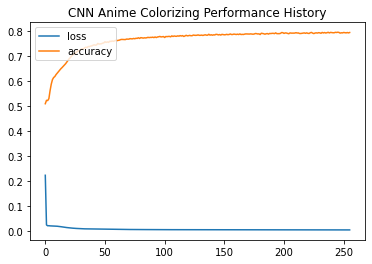

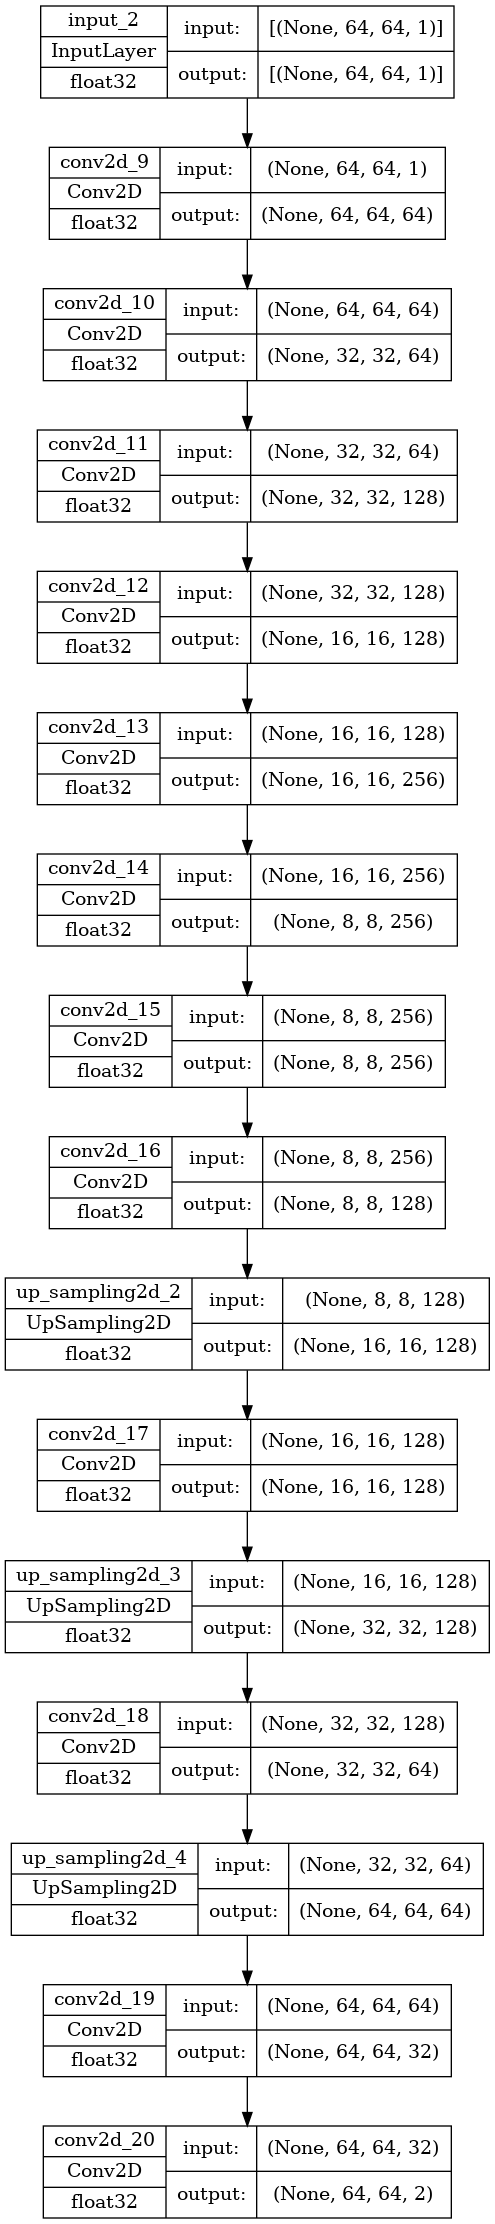

<Figure size 432x288 with 0 Axes>

In [19]:
plotCostHistory(model_history.history, title=str.format(
    "CNN {0} Performance History", "Anime Colorizing"))

tf.keras.utils.plot_model(
    model, to_file=str.format('cnn_{0}_model.png', "Anime Colorizing"), show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
    layer_range=None
)
